In [15]:
import os
import json
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Parameters
`indir` : input directory (data pull)

`indir_annotations` : annotations directory (calculated)

`indir_images` : input images

`ext_images` : the filename extension for the images

In [16]:
indir = '../Data_Pull'
indir_annotations = os.path.join(indir,'subject_annotations')
indir_images = os.path.join(indir,'subject_images')

ext_images = '*.jpg'

outdir = './20200911'

## Read in images and annotations

Reads in JSON and images.

In [17]:
annotations_table = pd.DataFrame.from_dict({
    'annotation_path' : glob(os.path.join(indir_annotations,'*.json')) })

In [18]:
images_table = pd.DataFrame.from_dict({
    'image_path' : glob(os.path.join(indir_images, ext_images)) })

Extracts the ID from the filename pattern "XXXX.yyy" and "XXXX_Anno.json'

In [19]:
annotations_table['ID'] = annotations_table.annotation_path.apply(lambda x : os.path.basename(x).split('_')[0])
images_table['ID'] = images_table.image_path.apply(lambda x : os.path.basename(x).split('.')[0])

Join the two tables

In [20]:
images_table = images_table.set_index('ID')
annotations_table = annotations_table.set_index('ID')

DATA = annotations_table.join(images_table)

Loads the JSON into a string

In [21]:
def getJSON(annotation_path):
    if not os.path.isfile(annotation_path):
        return None
    
    with open(annotation_path,'r') as f:
        s = f.readline()

        J = json.loads(s)

        return J

Adds the JSON column to the DATA table

In [22]:
DATA['JSON'] = DATA.annotation_path.apply(getJSON)

Returns the number of annotations inside the JSON

In [23]:
def getNannotations(J):    
    return len(J[0]['value'])

In [24]:
DATA['nPolygons'] = DATA.JSON.apply(getNannotations)

Reads in all the images into the DATA table

In [25]:
DATA['images'] = DATA.image_path.apply(plt.imread)

Extracts the contours from the JSON

In [26]:
def getContours(J):
    shapes=[]

    for task in J:
        for iannotation, annotation in enumerate(task['value']):
            
            if 'points' in annotation.keys():
                pp = np.array([[p['x'], p['y']] for p in annotation['points']],dtype='int32')

                shapes.append(pp)
            
    return np.array(shapes)

In [27]:
DATA['contours'] = DATA.JSON.apply(getContours)

C:\Users\tpeng\miniconda3\envs\mnp-ai\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Given a mask and a poligon, adds a positive pixel for each pixel inside the polygon

In [28]:
def addPolygon(m0, polygon, c=1):
    m=np.zeros_like(m0, dtype=np.int8)
    m=cv2.fillPoly(m, np.array([polygon],dtype=np.int32), c)
    
    return m0+m

Uses `addPolygon` to add all contours in `Jc` to the mask of the same shape as `J_img`. Consensus: majority voting.

In [29]:
def getMask(J_img, Jc):
    m=np.zeros_like(J_img, dtype=np.int8)

    for poly in Jc.tolist():
        m = addPolygon(m, poly)
        
    # Consensus
    if m.max()>0:
        m=m/m.max() >= 0.5
    
    return m

Transforms each image into a grayscale by taking the average across channels

In [30]:
DATA['images_gray']=DATA.images.map(lambda x : x.mean(axis=-1) if len(list(x.shape))>2 else x)

Create the masks

In [31]:
DATA['masks'] = DATA.apply(lambda x : getMask(x['images_gray'], x['contours']),axis=1)

In [32]:
def getPatches(ims, size=256, stride=256):
    off = int((stride-size)/2)
    # Crop to multiple of size   
    patches_list = [ im[(x0+off):(x0+size+off),(y0+off):(y0+size+off),np.newaxis] 
                    for im in ims
                    for x0 in range(0,int(np.floor(im.shape[0]/stride)*stride)-stride,stride) 
                    for y0 in range(0,int(np.floor(im.shape[1]/stride)*stride)-stride,stride)
                     ]
    
    return np.stack(patches_list)
    

getPatches(DATA.images_gray.tolist()).shape

(516, 256, 256, 1)

In [33]:
x_in = getPatches(DATA.images_gray.tolist(),size=256,stride=256)/2**12
x_lb = getPatches(DATA.masks.tolist(),size=68,stride=256)

In [34]:
x_lb_nonempty = x_lb.sum(axis=-1).sum(axis=-1).sum(axis=-1)>0

x_lb_nonempty.sum()

22

In [35]:
x_in_ok = x_in[x_lb_nonempty,...]
x_lb_ok = x_lb[x_lb_nonempty,...]

In [36]:
def trainingExists():
    return os.path.isdir(os.path.join(outdir,'assets'))

In [37]:
from keras_unet.models import vanilla_unet
from tensorflow.keras.models import load_model

if trainingExists:
    model = load_model(outdir)
else:
    model = vanilla_unet(input_shape=(256, 256, 1))
    
    model.compile("sgd", "binary_crossentropy", ["acc"])

In [38]:
from keras_unet.utils import get_augmented

if not trainingExists():
    train_gen = get_augmented(
        x_in_ok, x_lb_ok, batch_size=10,
        data_gen_args = dict(
#            rotation_range=15.,
#            width_shift_range=0.05,
#            height_shift_range=0.05,
#            shear_range=50,
#            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant'
        ))

    history = model.fit(
        train_gen,
        steps_per_epoch=100,
        epochs=1000)
    
    if not os.path.isdir(outdir):
        os.makedirs(outdir)

        model.save(outdir)

In [39]:
if not trainingExists():
    from keras_unet.utils import plot_segm_history

    plot_segm_history(history, metrics=['acc'], losses=['loss'])

In [40]:
x_lb_ok_pred = model.predict(x_in_ok)

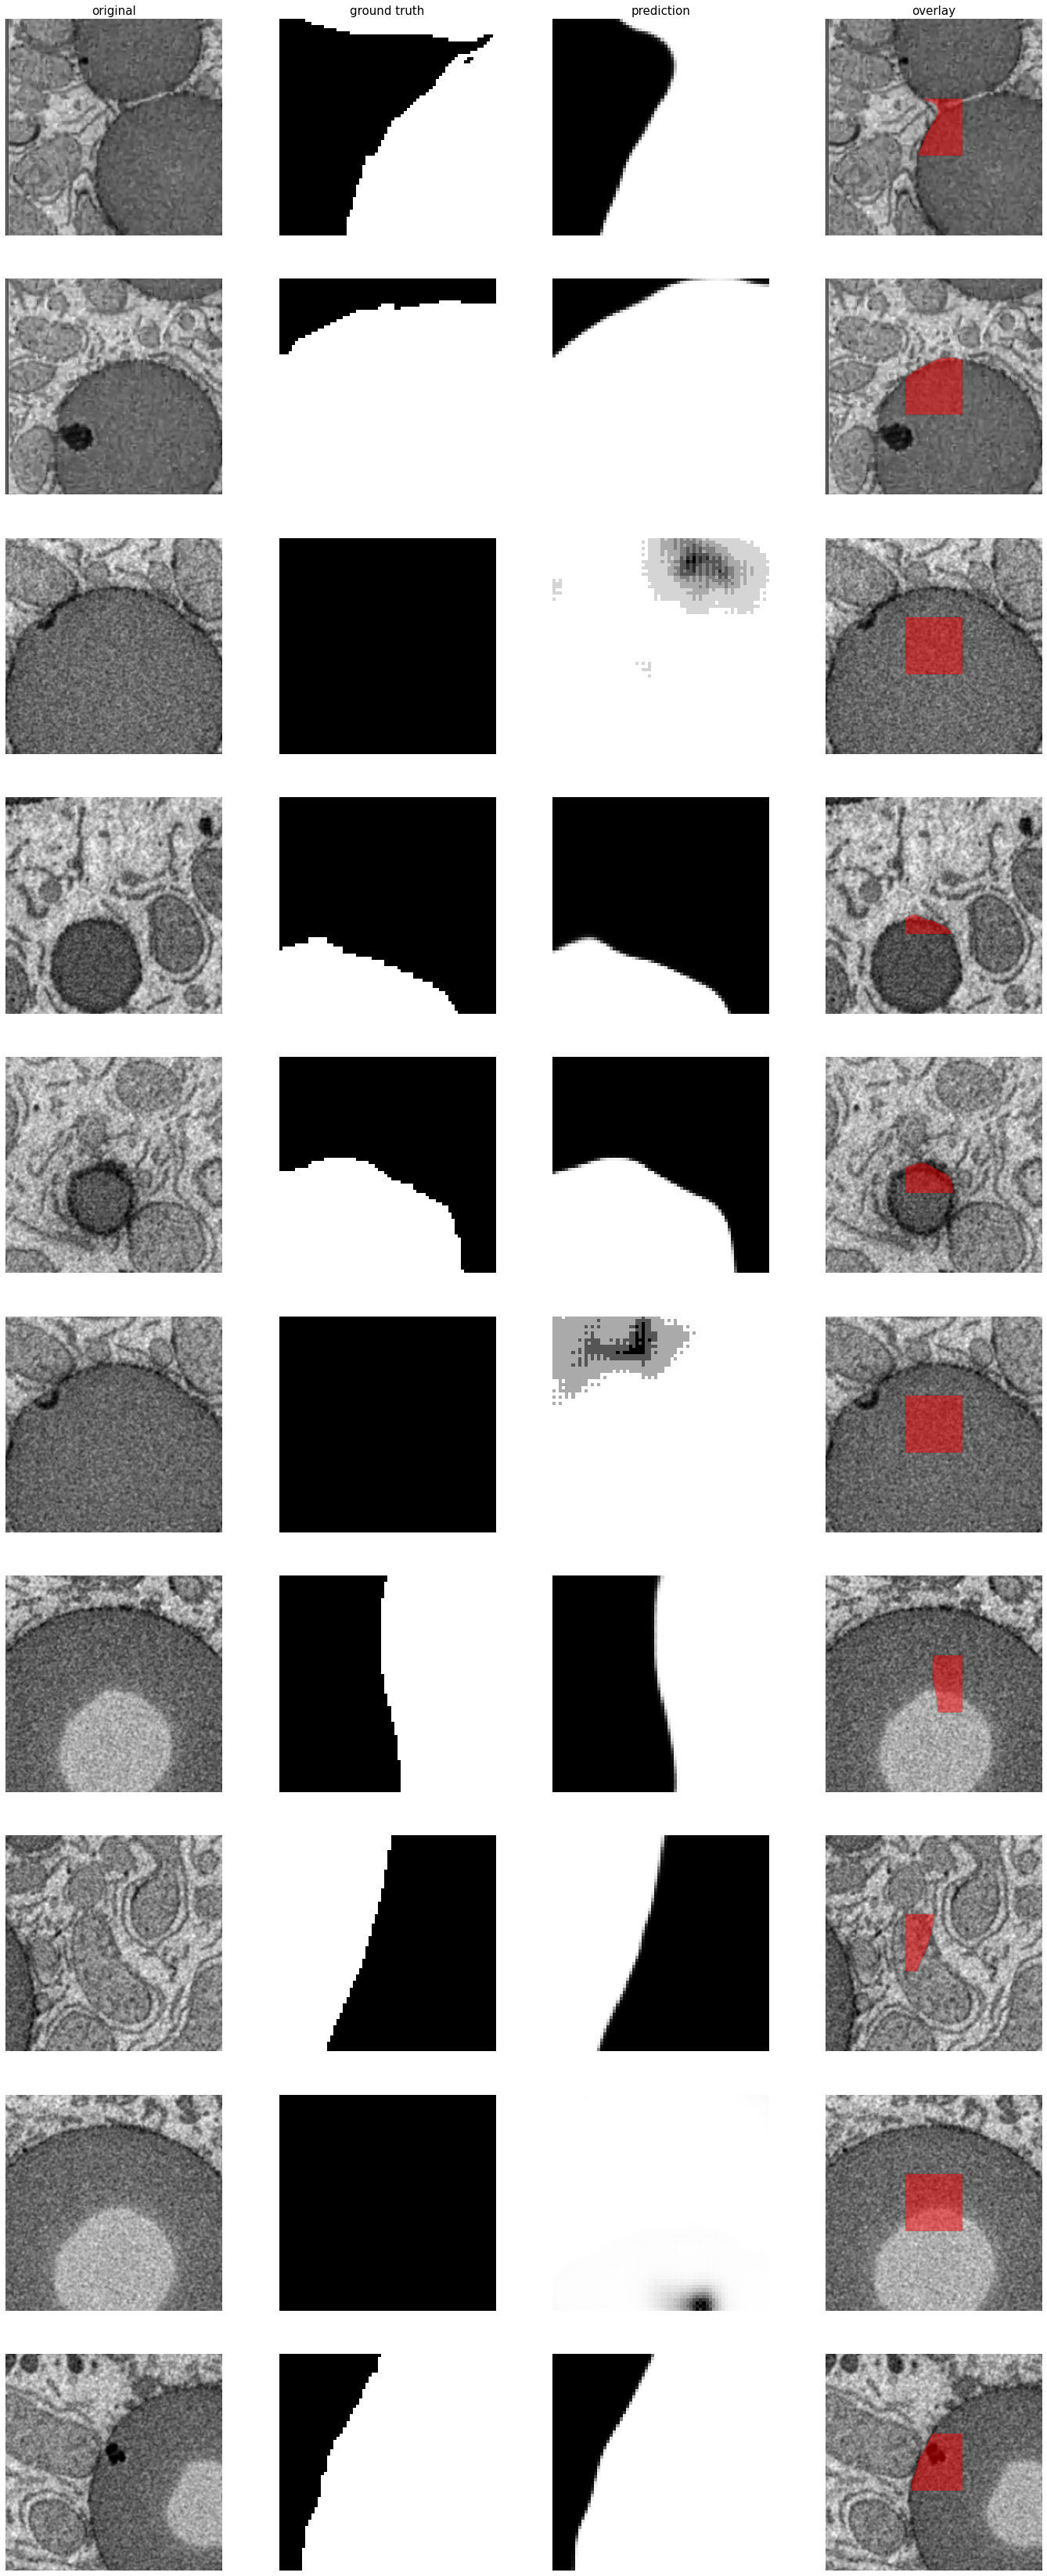

In [41]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_in_ok, 
          mask_imgs=x_lb_ok,
          pred_imgs=x_lb_ok_pred,
          nm_img_to_plot=10, figsize=6)


# Segment the entire image

In [94]:
def predict_image(model, im):
    ishape = model.input.shape[1:3]
    oshape = model.output.shape[1:3]
    
    ntiles = np.ceil(np.array(im.shape)/np.array(oshape)).astype(int)

    dx = int((ishape[0]-oshape[0])/2)
    dy = int((ishape[1]-oshape[1])/2)

    im1 = np.zeros( ntiles*oshape+2*np.array([dx,dy]) )
    im1[dx:dx+im.shape[0],dy:dy+im.shape[1]] = im
    
    ipatches = np.stack([ 
            im1[x0:x0+ishape[0], y0:y0+ishape[1], np.newaxis]/2**12 
                for x0 in range(0,im1.shape[0]-ishape[0],oshape[0])
                for y0 in range(0,im1.shape[1]-ishape[1],oshape[1]) ])

    opatches = model.predict(ipatches)
    
    out = np.zeros( ntiles*np.array(oshape) ,dtype=np.bool8)

    ipatch=0
    for x0 in range(0,im1.shape[0]-ishape[0],oshape[0]):
        for y0 in range(0,im1.shape[1]-ishape[0],oshape[1]):
            out[x0:x0+oshape[0],y0:y0+oshape[1]] = opatches[ipatch,:,:,0]>.5
            ipatch+=1
            
    return out[0:im.shape[0],0:im.shape[1]]

In [95]:
im = DATA.images_gray[0]

imp = predict_image(model, im)

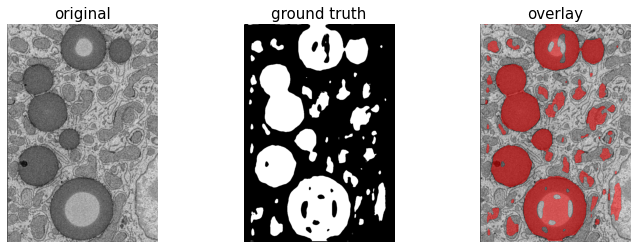

In [96]:
plot_imgs(org_imgs=np.array([im]),mask_imgs=np.array([imp]))